# 1. Učitavanje podataka

Prije učitavanja potrebno je dodati datasetove: [handcrafted](https://www.kaggle.com/dataset/206d79191cb67e3d506989a8d420f83172028279e0546d789829ed041eb16c7c), [fma-small](https://www.kaggle.com/aaronyim/fma-small)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings

warnings.simplefilter('ignore', UserWarning)

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Učitajmo feature
features = pd.read_csv('/kaggle/input/handcrafted/handcrafted.csv', index_col='track_id')

# Učitajmo podatke o žanrovima
tracks = pd.read_csv('/kaggle/input/fma-small/fma_metadata/fma_metadata/tracks.csv', index_col=0, header=[0, 1])
genre_encoder = LabelEncoder()
features['genre'] = genre_encoder.fit_transform(tracks.loc[features.index, ('track', 'genre_top')])

# Razdvojimo feature i labele
X = features.drop(['genre'], axis=1).values
y = features['genre'].values

# Standardizirana verzija featura
X_scaled = StandardScaler().fit_transform(X)

Podijelimo podatke na train(80%) i test(20%)

In [3]:
from sklearn.model_selection import train_test_split

train_ids, test_ids = train_test_split(features.index, stratify=features['genre'], test_size=0.2, random_state=42)
X_train = features.loc[train_ids].drop(['genre'], axis=1).values
y_train = features.loc[train_ids, 'genre'].values
X_test = features.loc[test_ids].drop(['genre'], axis=1).values
y_test = features.loc[test_ids, 'genre'].values

# 2. Vizualizacija podataka
## 2.1. Analiza glavnih komponenti (PCA)
Prikažimo varijancu objašnjenu sa svakom od glavnih komponenti, kao i kumulativnu varijancu objašnjenu uključivanjem svake naredne glavne komponente u našem projiciranom datasetu.

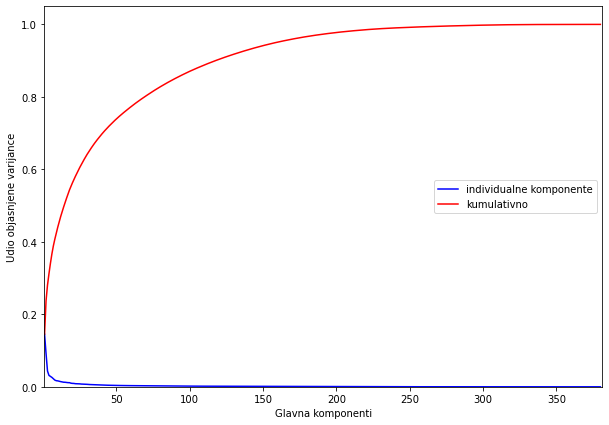

In [4]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

plt.figure(figsize=(10,7))

explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_cummulative = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1,X_pca.shape[1]+1), explained_variance_ratio, label='individualne komponente', c='b')
plt.plot(range(1,X_pca.shape[1]+1), explained_variance_ratio_cummulative, label='kumulativno', c='r')

plt.ylabel('Udio objasnjene varijance')
plt.xlabel('Glavna komponenti')
plt.xlim(0.75,X_pca.shape[1]+1.25)
plt.ylim(0,1.05)
plt.legend(loc='center right')
plt.show()

Pogledajmo kako naši podaci izgledaju kada se projiciraju na prve dvije glavne komponente:

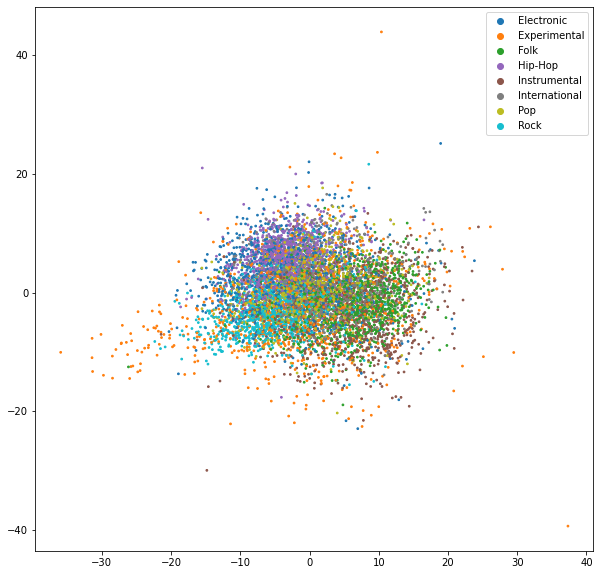

In [5]:
plt.figure(figsize=(10,10))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], 3, c=y, cmap='tab10')
plt.legend(scatter.legend_elements()[0], genre_encoder.classes_)
plt.show()

## 2.2. Vizualizacija pomoću t-SNE

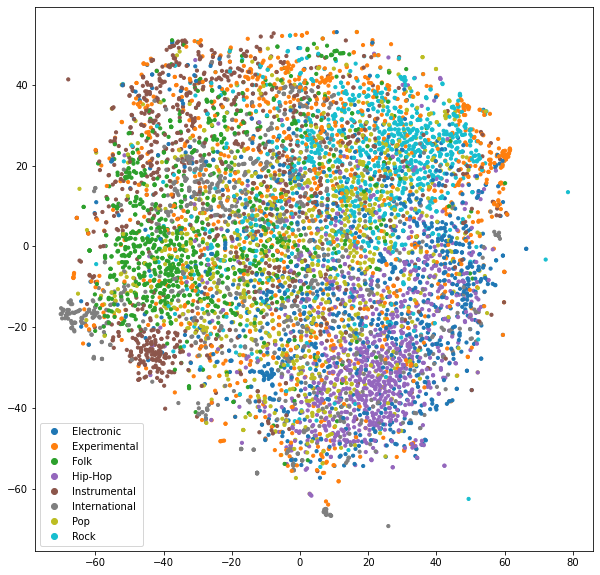

In [6]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10,10))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], 10, c=y, cmap='tab10')
plt.legend(scatter.legend_elements()[0], genre_encoder.classes_)
plt.show()

# 3. Modeli

Za svaki model pronaći ćemo najbolje parametre pomoću GridSearchCV, izračunati točnost najboljeg modela na unakrsnoj validaciji i testnim primjerima te prikazati matricu konfuzije na testnim primjerima.

In [7]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix

def print_cv_test_accuracy(clf):
    print(f'Najbolja točnost na unakrsnoj validaciji: {100*clf.best_score_:.2f}%')
    print(f'Točnost na test: {100*accuracy_score(y_test, clf.predict(X_test)):.2f}%')

def plot_confusion_matrix2(clf):
    plt.figure(figsize=(7,7))
    plot_confusion_matrix(clf, X_test, y_test, display_labels=genre_encoder.classes_, normalize='true', ax=plt.gca(), cmap='Blues')
    plt.xticks(rotation=90)
    plt.show()
    
def plot_feature_importances(estimator, n, title='', figsize=(12,6)):
    plt.figure(figsize=figsize)
    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1][:n]
    plt.plot(range(n), importances[indices], 'o', color='gray')
    plt.title(title)
    plt.ylabel('Vaznost značajke')
    plt.xticks(range(n), features.drop(['genre'], axis=1).columns.values[indices], rotation=90)
    plt.tight_layout()
    plt.grid(True,linestyle='--')
    plt.show()

## 3.1. Stablo odlučivanja

Najbolja točnost na unakrsnoj validaciji: 35.56%
Točnost na test: 34.75%


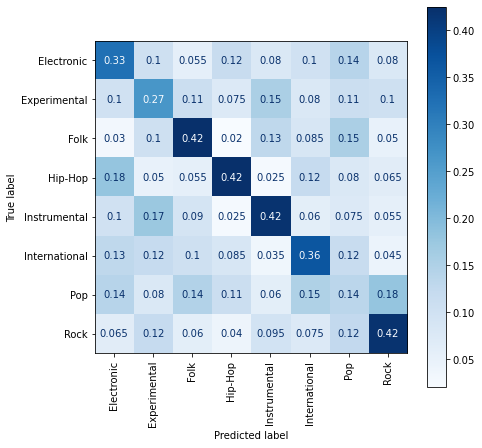

In [8]:
from sklearn.tree import DecisionTreeClassifier

params_dtc = {
    "dtc__criterion": ["gini", "entropy"],
    "dtc__splitter": ["best", "random"],
}

pipe_dtc = Pipeline([
    ('dtc', DecisionTreeClassifier())
])

clf_dtc = GridSearchCV(pipe_dtc, params_dtc, scoring='accuracy', n_jobs=-1, cv=10)
clf_dtc.fit(X_train, y_train)
print_cv_test_accuracy(clf_dtc)
plot_confusion_matrix2(clf_dtc)

## 3.2. Slučajna šuma

Najbolja točnost na unakrsnoj validaciji: 55.07%
Točnost na test: 53.25%


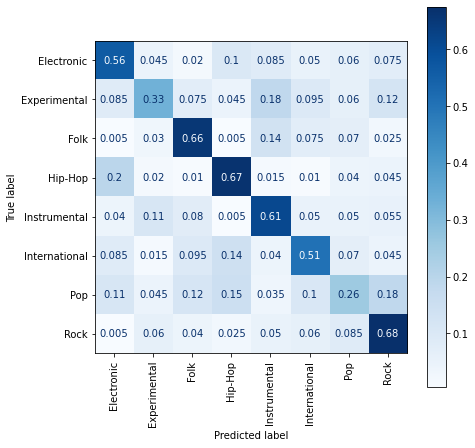

In [9]:
from sklearn.ensemble import RandomForestClassifier

params_rfc = {
    'criterion': ['gini'],
    'max_depth': [None],
    'n_estimators': [1000],
}

rfc = RandomForestClassifier()

clf_rfc = GridSearchCV(rfc, params_rfc, scoring='accuracy', n_jobs=-1, cv=10)
clf_rfc.fit(X_train, y_train)
print_cv_test_accuracy(clf_rfc)
plot_confusion_matrix2(clf_rfc)

### 3.2.1. Važnost značajki
Prikažimo važnosti značajki dobivene iz klasifikatora slučajne šume. Značajke koje se nalaze bliže korijenu stabla imaju veći utjecaj na predikciju i prema tome se mogu smatrati važnijima.

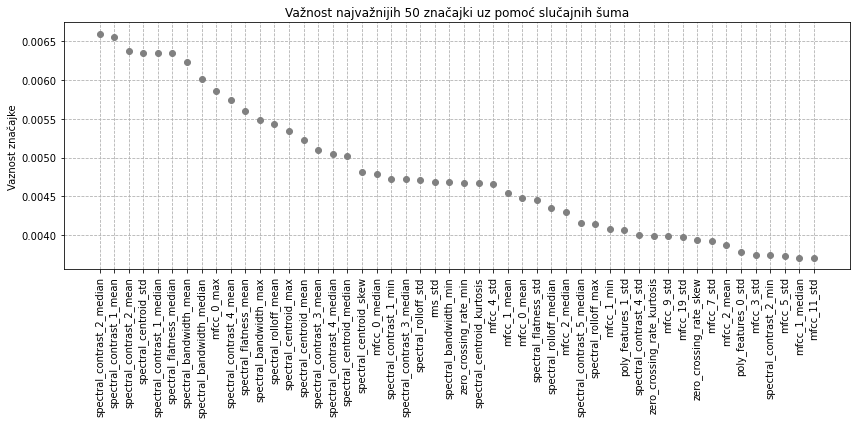

In [10]:
plt.figure(figsize=(12,6))
n_importances = 50
importances = clf_rfc.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1][:n_importances]
plt.plot(range(n_importances), importances[indices], 'o', color='gray')
plt.title(f'Važnost najvažnijih {n_importances} značajki uz pomoć slučajnih šuma')
plt.ylabel('Vaznost značajke')
plt.xticks(range(n_importances), features.drop(['genre'], axis=1).columns.values[indices], rotation=90)
plt.tight_layout()
plt.grid(True,linestyle='--')
plt.show()

## 3.3. Logistička regresija
Za odabir značajki koristimo slučajnu šumu.

Najbolja točnost na unakrsnoj validaciji: 53.21%
Točnost na test: 52.25%


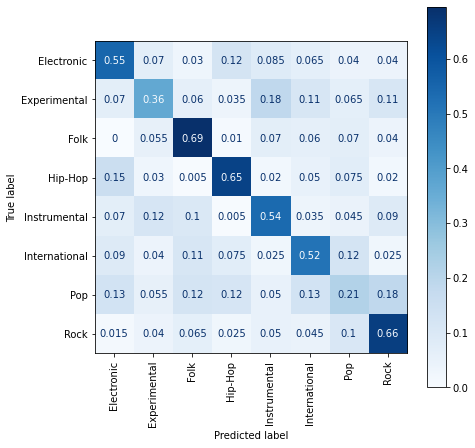

In [11]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

params_log = {
    'feature_selection__threshold': ['median'],
    'log__C': [2],
}

pipe_log = Pipeline([
    # Za odabir značajki koristimo slučajnu šumu s prethodno dobivenim najboljim parametrima
    ('feature_selection', SelectFromModel(RandomForestClassifier(**clf_rfc.best_params_))),
    ('scaler', StandardScaler()),
    ('log', LogisticRegression(max_iter=1000)),
])

clf_log = GridSearchCV(pipe_log, params_log, scoring='accuracy', n_jobs=-1, cv=10)
clf_log.fit(X_train, y_train)
print_cv_test_accuracy(clf_log)
plot_confusion_matrix2(clf_log)

# 3.4 Metoda potpornih vektora

Najbolja točnost na unakrsnoj validaciji: 60.29%
Točnost na test: 57.63%


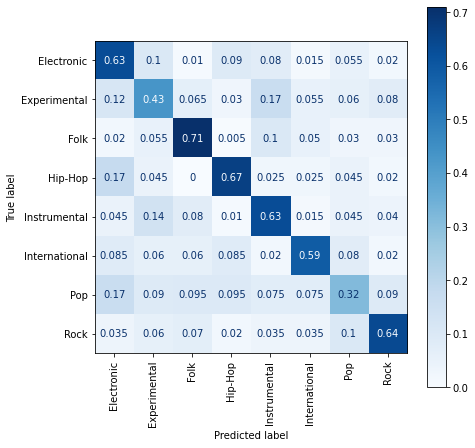

In [12]:
from sklearn.svm import SVC

params_svm = {
    'feature_selection__threshold': ['0.9*median'],
    "svm__C": [4],
    "svm__kernel": ['rbf'],
}

pipe_svm = Pipeline([
    # Za odabir značajki koristimo slučajnu šumu s prethodno dobivenim najboljim parametrima
    ('feature_selection', SelectFromModel(RandomForestClassifier(**clf_rfc.best_params_))),
    ('scaler', StandardScaler()),
    ('svm', SVC()),
])

clf_svm = GridSearchCV(pipe_svm, params_svm, scoring='accuracy', n_jobs=-1, cv=10)
clf_svm.fit(X_train, y_train)
print_cv_test_accuracy(clf_svm)
plot_confusion_matrix2(clf_svm)

## 3.5. AdaBoost

Najbolja točnost na unakrsnoj validaciji: 47.74%
Točnost na test: 46.31%


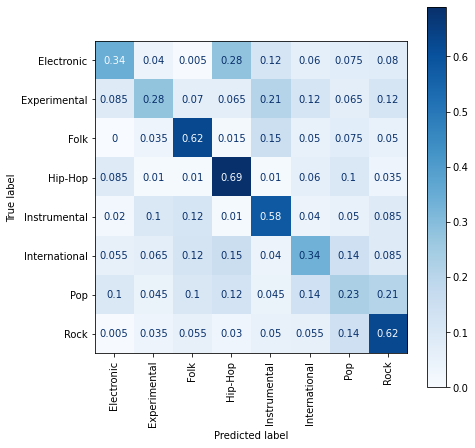

In [13]:
from sklearn.ensemble import AdaBoostClassifier

params_ada = {
    'n_estimators': [180],
    'learning_rate': [0.3],
}

ada = AdaBoostClassifier()

clf_ada = GridSearchCV(ada, params_ada, scoring='accuracy', n_jobs=-1, cv=10)
clf_ada.fit(X_train, y_train)
print_cv_test_accuracy(clf_ada)
plot_confusion_matrix2(clf_ada)

### 3.5.1. Važnost značajki

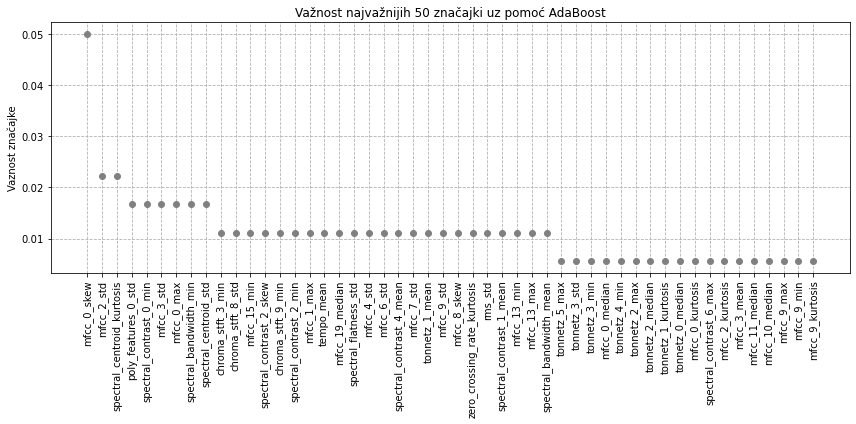

In [14]:
plot_feature_importances(clf_ada.best_estimator_, 50, 'Važnost najvažnijih 50 značajki uz pomoć AdaBoost')

## 3.6. XGBoost

Najbolja točnost na unakrsnoj validaciji: 58.96%
Točnost na test: 57.50%


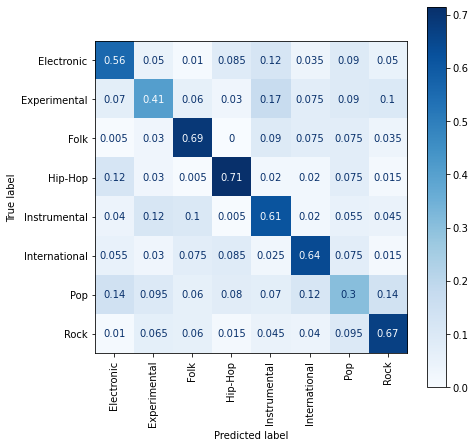

In [16]:
import xgboost

params_xgb = {
    'eta': [0.25],
    'max_depth': [6],
    'n_estimators': [180],
}

xgb = xgboost.XGBClassifier(objective='multi:softmax', n_classes=len(genre_encoder.classes_), n_jobs=-1)
clf_xgb = GridSearchCV(xgb, params_xgb, scoring='accuracy', n_jobs=-1, cv=10)
clf_xgb.fit(X_train, y_train)
print_cv_test_accuracy(clf_xgb)
plot_confusion_matrix2(clf_xgb)

### 3.6.1. Važnost značajki

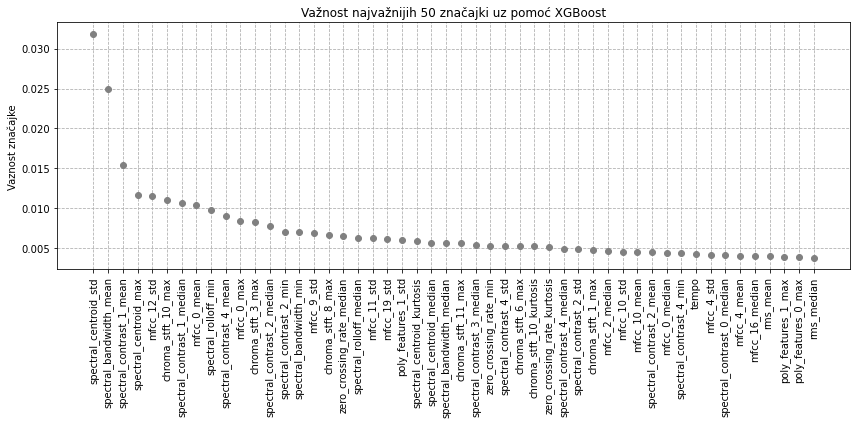

In [17]:
plot_feature_importances(clf_xgb.best_estimator_, 50, 'Važnost najvažnijih 50 značajki uz pomoć XGBoost')

# 4. Analiza modela
Analizirajmo žanrove pjesama koje modeli nisu mogli točno predvidjeti.

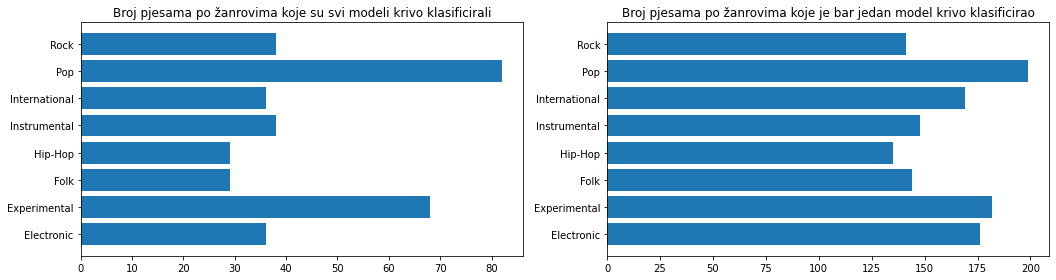

In [18]:
classifiers = {
    'Stablo odlučivanja': clf_dtc,
    'Slučajna šuma': clf_rfc,
    'Logistička regresija': clf_log,
    'Metoda potpornih vektora': clf_svm,
    'AdaBoost': clf_ada,
    'XGBoost': clf_xgb,
}

predictions = pd.DataFrame(index=test_ids)
for name, clf in classifiers.items():
    predictions[name] = clf.predict(X_test)

wrong = predictions.ne(y_test, axis=0)
wrong_all = features.loc[wrong[wrong.all(axis=1)].index, 'genre']
wrong_any = features.loc[wrong[wrong.any(axis=1)].index, 'genre']
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
plt.barh(genre_encoder.classes_, pd.Series(wrong_all.value_counts().sort_index()))
plt.title('Broj pjesama po žanrovima koje su svi modeli krivo klasificirali')
plt.subplot(1, 2, 2)
plt.barh(genre_encoder.classes_, pd.Series(wrong_any.value_counts().sort_index()))
plt.title('Broj pjesama po žanrovima koje je bar jedan model krivo klasificirao')
plt.tight_layout()

Pustimo slučajno odabranu pjesmu iz skupa pjesama koje su svi modeli krivo klasificirali:

In [19]:
from IPython.display import Audio

def get_song_file(song_id):
    song_id_str = f'{song_id:06}'
    return f'/kaggle/input/fma-small/fma_small/fma_small/{song_id_str[:3]}/{song_id_str}.mp3'

track_id = wrong_all.sample(1).index[0]
track_predictions = predictions.loc[track_id]
print(f"{'ŽANR': <25}- {genre_encoder.classes_[features.loc[track_id, 'genre']]}")
print('PREDVIĐENI ŽANROVI:')
for clf, genre in track_predictions.items():
    print(f'{clf: <25}- {genre_encoder.classes_[genre]}')
Audio(get_song_file(track_id))

ŽANR                     - Experimental
PREDVIĐENI ŽANROVI:
Stablo odlučivanja       - Pop
Slučajna šuma            - Electronic
Logistička regresija     - Hip-Hop
Metoda potpornih vektora - Electronic
AdaBoost                 - Pop
XGBoost                  - Hip-Hop
